# Match Score Prediction Model

## Imports and Configuration

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration
CURRENT_YEAR = 2025
LOOKBACK_MATCHES = 10
N_SIMULATIONS = 100
APRIL_START = f'{CURRENT_YEAR}-04-01'


## Data Loading and Preparation

In [21]:
def load_data(filepath):
    """Load and preprocess match data"""
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter for analysis
    df_played = df[df['is_played'] == True].copy()
    df_unplayed = df[df['is_played'] == False].copy()
    
    # Focus on April+ matches for prediction
    df_unplayed = df_unplayed[pd.to_datetime(df_unplayed['date']) >= pd.to_datetime(APRIL_START)]
    
    print(f"Data loaded: {len(df)} total matches")
    print(f"Played matches: {len(df_played)}")
    print(f"Unplayed matches (April+): {len(df_unplayed)}")
    
    return df, df_played, df_unplayed

## Team Performance Analysis

In [22]:
def analyze_team_performance(data, team_id, current_date, is_home=True):
    """
    Detailed analysis of team performance in home/away matches
    Returns both recent form and season-long statistics
    """
    if is_home:
        team_matches = data[(data['home_team_id'] == team_id) & 
                           (data['date'] < current_date)].copy()
        team_matches['goals_scored'] = team_matches['home_goals']
        team_matches['goals_conceded'] = team_matches['away_goals']
    else:
        team_matches = data[(data['away_team_id'] == team_id) & 
                           (data['date'] < current_date)].copy()
        team_matches['goals_scored'] = team_matches['away_goals']
        team_matches['goals_conceded'] = team_matches['home_goals']
    
    if len(team_matches) == 0:
        return None
    
    # Sort by date descending
    team_matches = team_matches.sort_values('date', ascending=False)
    played_matches = team_matches[team_matches['is_played'] == True]
    
    if len(played_matches) == 0:
        return None
    
    # Recent form (last N matches)
    recent_matches = played_matches.head(LOOKBACK_MATCHES)
    
    # Create performance profile
    performance = {
        'team_id': team_id,
        'is_home': is_home,
        'total_matches': len(played_matches),
        'recent_matches': len(recent_matches),
        
        # Recent form
        'recent_avg_scored': recent_matches['goals_scored'].mean(),
        'recent_avg_conceded': recent_matches['goals_conceded'].mean(),
        'recent_win_rate': (recent_matches['goals_scored'] > recent_matches['goals_conceded']).mean(),
        'recent_clean_sheets': (recent_matches['goals_conceded'] == 0).mean(),
        'recent_failed_to_score': (recent_matches['goals_scored'] == 0).mean(),
        
        # Season-long performance
        'season_avg_scored': played_matches['goals_scored'].mean(),
        'season_avg_conceded': played_matches['goals_conceded'].mean(),
        'season_win_rate': (played_matches['goals_scored'] > played_matches['goals_conceded']).mean(),
        
        # Distribution metrics
        'median_goals': played_matches['goals_scored'].median(),
        'max_goals': played_matches['goals_scored'].max(),
        'min_goals': played_matches['goals_scored'].min(),
        
        # Streaks
        'current_win_streak': calculate_streak(recent_matches, 'win'),
        'current_goal_streak': calculate_streak(recent_matches, 'goal'),
    }
    
    return performance

def calculate_streak(matches, streak_type):
    """Calculate current win or goal streak"""
    if len(matches) == 0:
        return 0
    
    streak = 0
    for _, match in matches.iterrows():
        if streak_type == 'win':
            condition = match['goals_scored'] > match['goals_conceded']
        else:  # goal streak
            condition = match['goals_scored'] > 0
            
        if condition:
            streak += 1
        else:
            break
    return streak

## Feature Engineering

In [23]:
def create_match_features(data, match_row):
    """Create comprehensive features for a match"""
    home_team = match_row['home_team_id']
    away_team = match_row['away_team_id']
    match_date = match_row['date']
    
    # Get home team performance (as home team)
    home_performance = analyze_team_performance(data, home_team, match_date, is_home=True)
    
    # Get away team performance (as away team)
    away_performance = analyze_team_performance(data, away_team, match_date, is_home=False)
    
    # Create features dictionary
    features = {
        'match_id': match_row['match_id'],
        'date': match_date,
        'league_id': match_row['league_id'],
        'season': match_row['season'],
        'home_team_id': home_team,
        'away_team_id': away_team,
    }
    
    # Add home team features
    if home_performance:
        for k, v in home_performance.items():
            if k not in ['team_id', 'is_home']:
                features[f'home_{k}'] = v
    
    # Add away team features
    if away_performance:
        for k, v in away_performance.items():
            if k not in ['team_id', 'is_home']:
                features[f'away_{k}'] = v
    
    # Add head-to-head features if available
    h2h_stats = calculate_head_to_head(data, home_team, away_team, match_date)
    features.update(h2h_stats)
    
    return features

def calculate_head_to_head(data, team1, team2, before_date):
    """Calculate head-to-head statistics between two teams"""
    h2h_matches = data[
        (((data['home_team_id'] == team1) & (data['away_team_id'] == team2)) |
         ((data['home_team_id'] == team2) & (data['away_team_id'] == team1))) &
        (data['date'] < before_date) &
        (data['is_played'] == True)
    ].copy()
    
    if len(h2h_matches) == 0:
        return {}
    
    h2h_matches['team1_goals'] = h2h_matches.apply(
        lambda x: x['home_goals'] if x['home_team_id'] == team1 else x['away_goals'], axis=1)
    h2h_matches['team2_goals'] = h2h_matches.apply(
        lambda x: x['away_goals'] if x['home_team_id'] == team1 else x['home_goals'], axis=1)
    
    return {
        'h2h_matches': len(h2h_matches),
        'h2h_avg_team1_scored': h2h_matches['team1_goals'].mean(),
        'h2h_avg_team2_scored': h2h_matches['team2_goals'].mean(),
        'h2h_team1_win_rate': (h2h_matches['team1_goals'] > h2h_matches['team2_goals']).mean(),
        'h2h_draw_rate': (h2h_matches['team1_goals'] == h2h_matches['team2_goals']).mean(),
    }

## Model Training

In [24]:
def train_models(df):
    """Train separate models for home and away goals"""
    # Prepare training data
    train_matches = df[df['is_played'] == True].copy()
    features_list = []
    
    for _, row in train_matches.iterrows():
        try:
            features = create_match_features(df, row)
            features['home_goals'] = row['home_goals']
            features['away_goals'] = row['away_goals']
            features_list.append(features)
        except Exception as e:
            print(f"Error processing match {row['match_id']}: {str(e)}")
            continue
    
    train_data = pd.DataFrame(features_list)
    
    # Define feature columns
    non_feature_cols = ['match_id', 'date', 'home_goals', 'away_goals', 
                       'home_team_id', 'away_team_id']
    feature_columns = [col for col in train_data.columns 
                      if col not in non_feature_cols]
    
    # Handle categorical variables
    le_league = LabelEncoder()
    le_season = LabelEncoder()
    
    train_data['league_id_encoded'] = le_league.fit_transform(train_data['league_id'])
    train_data['season_encoded'] = le_season.fit_transform(train_data['season'])
    
    # Update feature columns to use encoded versions
    feature_columns = [col for col in feature_columns if col not in ['league_id', 'season']]
    feature_columns.extend(['league_id_encoded', 'season_encoded'])
    
    # Handle missing values
    train_data[feature_columns] = train_data[feature_columns].fillna(train_data[feature_columns].mean())
    
    # Split data
    X = train_data[feature_columns]
    y_home = train_data['home_goals']
    y_away = train_data['away_goals']
    
    X_train, X_test, y_home_train, y_home_test, y_away_train, y_away_test = train_test_split(
        X, y_home, y_away, test_size=0.2, random_state=42)
    
    # Train home goals model
    home_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=3,
        random_state=42
    )
    home_model.fit(X_train, y_home_train)
    
    # Train away goals model
    away_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=3,
        random_state=42
    )
    away_model.fit(X_train, y_away_train)
    
    # Evaluate models
    print("\nModel Evaluation:")
    evaluate_model(home_model, X_test, y_home_test, "Home Goals")
    evaluate_model(away_model, X_test, y_away_test, "Away Goals")
    
    return home_model, away_model, feature_columns, le_league, le_season

def evaluate_model(model, X_test, y_test, name):
    """Evaluate model performance"""
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name} RMSE: {rmse:.2f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    pd.Series(model.feature_importances_, index=X_test.columns
             ).sort_values().tail(15).plot(kind='barh')
    plt.title(f'{name} - Feature Importance')
    plt.tight_layout()
    plt.show()

## Prediction Functions

In [25]:
def predict_matches(models, feature_columns, le_league, le_season, df_unplayed):
    """Predict goals for unplayed matches"""
    home_model, away_model = models
    
    # Prepare prediction data
    pred_features = []
    for _, row in df_unplayed.iterrows():
        try:
            features = create_match_features(df, row)
            pred_features.append(features)
        except Exception as e:
            print(f"Error processing match {row['match_id']}: {str(e)}")
            continue
    
    pred_data = pd.DataFrame(pred_features)
    
    # Encode categorical variables
    pred_data['league_id_encoded'] = le_league.transform(pred_data['league_id'])
    pred_data['season_encoded'] = le_season.transform(pred_data['season'])
    
    # Fill missing values
    pred_data[feature_columns] = pred_data[feature_columns].fillna(
        pred_data[feature_columns].mean())
    
    # Make predictions
    pred_data['pred_home_goals'] = home_model.predict(pred_data[feature_columns])
    pred_data['pred_away_goals'] = away_model.predict(pred_data[feature_columns])
    
    # Apply Poisson adjustment
    pred_data = apply_poisson_adjustment(pred_data)
    
    return pred_data

def apply_poisson_adjustment(pred_data):
    """Apply Poisson distribution to goal predictions"""
    # Run multiple simulations
    home_sims = np.zeros((len(pred_data), N_SIMULATIONS))
    away_sims = np.zeros((len(pred_data), N_SIMULATIONS))
    
    for i in range(N_SIMULATIONS):
        home_sims[:, i] = np.random.poisson(pred_data['pred_home_goals'])
        away_sims[:, i] = np.random.poisson(pred_data['pred_away_goals'])
    
    # Get most common prediction
    pred_data['home_goals_pred'] = np.round(np.mean(home_sims, axis=1))
    pred_data['away_goals_pred'] = np.round(np.mean(away_sims, axis=1))
    
    # Calculate confidence scores
    pred_data['home_confidence'] = np.mean(
        home_sims == pred_data['home_goals_pred'].values.reshape(-1, 1), axis=1)
    pred_data['away_confidence'] = np.mean(
        away_sims == pred_data['away_goals_pred'].values.reshape(-1, 1), axis=1)
    
    return pred_data

def custom_sort(df):
    """Custom sorting function for matches"""
    # Combine teams and create primary team column for sorting
    df['primary_team'] = df[['home_team_id', 'away_team_id']].min(axis=1)
    df['secondary_team'] = df[['home_team_id', 'away_team_id']].max(axis=1)
    
    # Sort by primary_team first, then date and secondary_team
    df_sorted = df.sort_values(by=['primary_team', 'date', 'secondary_team'])
    
    # Remove temporary columns
    return df_sorted.drop(columns=['primary_team', 'secondary_team'])

## Main Execution

Data loaded: 2549 total matches
Played matches: 2262
Unplayed matches (April+): 223

Model Evaluation:
Home Goals RMSE: 1.23


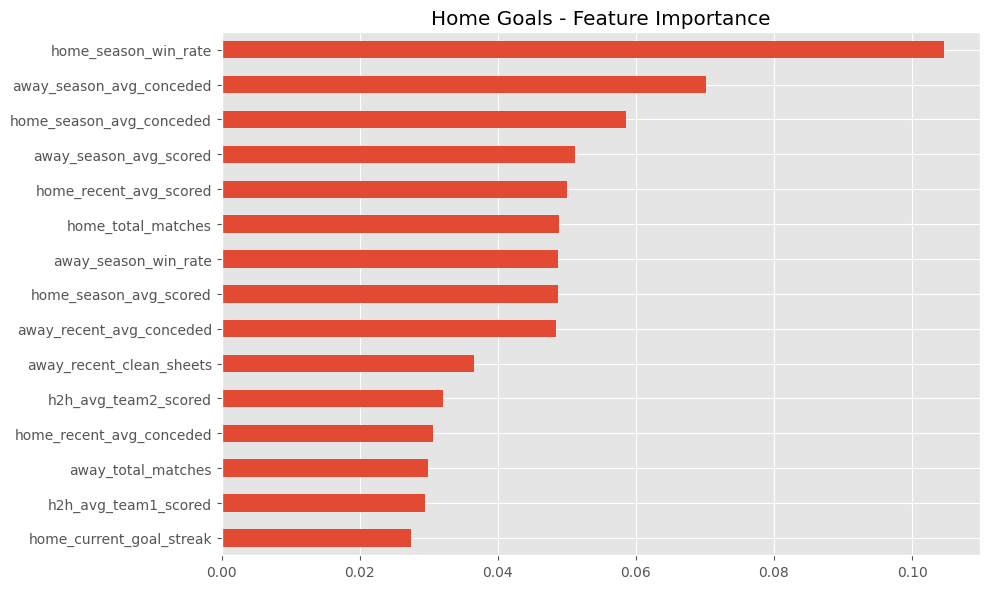

Away Goals RMSE: 1.08


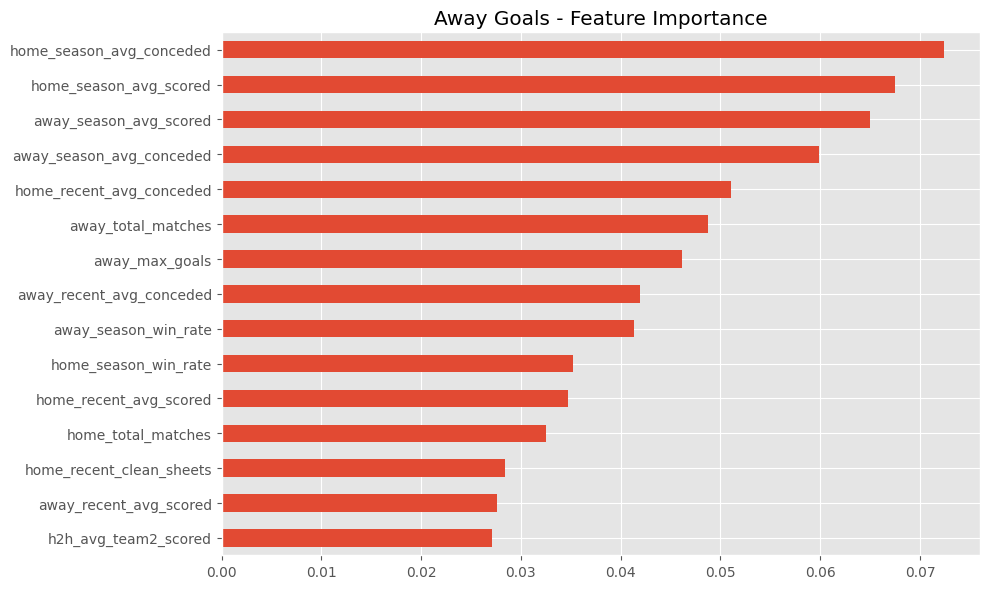


Applying custom sorting...

Last 10 sorted predictions:
     match_id       date league_id season  home_team_id  away_team_id  \
75       1805 2025-05-10       tr2  24/25            55            49   
200      1778 2025-04-21       tr2  24/25            50            55   
65       1788 2025-04-27       tr2  24/25            57            50   
24       1763 2025-04-13       tr2  24/25            51            53   
79       1791 2025-05-04       tr2  24/25            51            56   
8        1761 2025-04-13       tr2  24/25            55            52   
81       1771 2025-04-19       tr2  24/25            52            56   
23       1786 2025-04-27       tr2  24/25            56            53   
67       1743 2025-04-05       tr2  24/25            55            54   
68       1775 2025-04-20       tr2  24/25            57            54   

     home_goals_pred  away_goals_pred  home_confidence  away_confidence  \
75               2.0              1.0             0.24          

In [27]:
if __name__ == "__main__":
    # Load data
    df, df_played, df_unplayed = load_data("../data/processed_data/matches_scores_structured.csv")
    
    # Train models
    home_model, away_model, feature_columns, le_league, le_season = train_models(df)
    
    # Make predictions
    predictions = predict_matches((home_model, away_model), feature_columns, le_league, le_season, df_unplayed)
    
    # Prepare final output
    final_predictions = predictions[[
        'match_id', 'date', 'league_id', 'season',
        'home_team_id', 'away_team_id',
        'home_goals_pred', 'away_goals_pred',
        'home_confidence', 'away_confidence'
    ]].sort_values('date')
    
    # Add team names
    team_names = df[['home_team_id', 'home_team']].drop_duplicates().rename(
        columns={'home_team_id': 'team_id', 'home_team': 'team_name'})
    
    final_predictions = final_predictions.merge(
        team_names, left_on='home_team_id', right_on='team_id').rename(
        columns={'team_name': 'home_team'}).drop('team_id', axis=1)
    
    final_predictions = final_predictions.merge(
        team_names, left_on='away_team_id', right_on='team_id').rename(
        columns={'team_name': 'away_team'}).drop('team_id', axis=1)
        
    # Apply custom sorting
    print("\nApplying custom sorting...")
    sorted_final_predictions = custom_sort(final_predictions)

    print("\nLast 10 sorted predictions:")
    print(sorted_final_predictions.tail(10))

    # Save to CSV
    sorted_final_predictions.to_csv('../data/processed_data/matches_scores_predictions.csv', index=False)
    print("\nSorted predictions saved as 'matches_scores_predictions.csv'")
    
    # Show sample predictions
    print("\nSample predictions for April and later matches:")
    print(sorted_final_predictions.head(10))